<a href="https://colab.research.google.com/github/MistakenZebra/NLP-assignment/blob/master/Assignment_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import the pandas library to read our dataset
import pandas as pd
# Get the train/test split package from sklearn for preparing our dataset to
# train and test the model with
from sklearn.model_selection import train_test_split
# Import the numpy library to work with and manipulate the data
import numpy as np

In [74]:
# Reads a comma-separated value (CSV) file
dataset = pd.read_csv('/content/housing.csv')
# The path to your .csv file
# Remove any incomplete entries
dataset = dataset.dropna()
# View the first Ten rows of the dataset
print("Here are the first five rows of the dataset:")
dataset.head()


Here are the first five rows of the dataset:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1901054da0>,
      dtype=object)

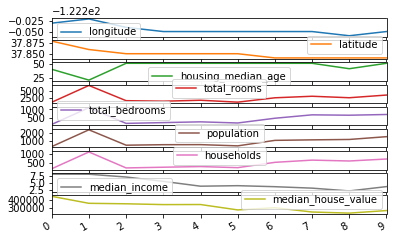

In [75]:
dataset.head(10).plot(subplots=True)

In [0]:
# We will predict the "median_house_value" column
Y = dataset['median_house_value']
# The remainder of the columns will be used to predict Y
# Select from the "longitude" column to the "median_income" column
X = dataset.loc[:,'longitude':'median_income']

In [0]:
# Splits the dataset so 70% is used for training and 30% for testing
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=2003)
# Converts the datasets to numpy arrays to work with our PyTorch model
x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()
# Convert the testing data
x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

In [0]:
# Import the pytorch library
import torch
# Import the 1D convolution layer
# Since we’re inputting a 1-dimensional row of data, we can’t use 2D or 3D
from torch.nn import Conv1d
# Import the max pooling layer
from torch.nn import MaxPool1d
# Import the flatten layer
from torch.nn import Flatten
# Import the linear layer
from torch.nn import Linear
# Import the ReLU activation function
from torch.nn.functional import relu
# Import the DataLoader and TensorDataset libraries from PyTorch
# to work with our datasets
from torch.utils.data import DataLoader, TensorDataset

In [79]:
# Import the SGD (stochastic gradient descent) package from pytorch for
# our optimizer
from torch.optim import Rprop
# Import the L1Loss (mean absolute error loss) package from pytorch for
# our performance measure
from torch.nn import L1Loss
# Import the R^2 score package from pytorch's ignite for our score measure
# This package is not installed by default so the next line does that
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

In [0]:
# Our class MUST be a subclass of torch.nn.Module
class CnnRegressor(torch.nn.Module):
# Define the initialization method
  def __init__(self, batch_size, inputs, outputs):
  # Initialize the superclass and store the parameters
    super(CnnRegressor, self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs
    # Define the input layer
    # (input channels, output channels, kernel size)
    self.input_layer = Conv1d(inputs, batch_size, 1)
    # Define a max pooling layer
    # (kernel size)
    self.max_pooling_layer = MaxPool1d(1)
    # Define another convolution layer
    self.conv_layer = Conv1d(batch_size, 128, 1)
    # Define a flatten layer
    self.flatten_layer = Flatten()
    # Define a linear layer
    # (inputs, outputs)
    self.linear_layer = Linear(128, 64)
    # Finally, define the output layer
    self.output_layer = Linear(64, outputs)
    # Define a method to feed inputs through the model
  def feed(self, input):
    # Reshape the entry so it can be fed to the input layer
    # Although we’re using 1D convolution, it still expects a 3D array to process in a 1D fashion
    input = input.reshape((self.batch_size, self.inputs, 1))
    # Get the output of the first layer and run it through the
    # the ReLU activation function
    output = relu(self.input_layer(input))
    # Get the output of the max pooling layer
    output = self.max_pooling_layer(output)
    # Get the output of the second convolution layer and run it
    # through the ReLU activation function
    output = relu(self.conv_layer(output))
    # Get the output of the flatten layer
    output = self.flatten_layer(output)
    # Get the output of the linear layer and run it through the
    # ReLU activation function
    output = self.linear_layer(output)
    # Finally, get the output of the output layer and return it
    output = self.output_layer(output)
    return output

In [81]:
# Define the batch size we'd like to use
batch_size = 400
# (batch size, X columns, Y columns)
model = CnnRegressor(batch_size, X.shape[1], 1)
# Set the model to use the GPU for processing
model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 400, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(400, 128, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
# This method will return the average L1 loss and R^2 score
# of the passed model on the passed DataLoader
def model_loss(model, dataset, train = False, optimizer = None):
# Cycle through the batches and get the average L1 loss
  performance = L1Loss()
  score_metric = R2Score()
  avg_loss = 0
  avg_score = 0
  count = 0
  for input, output in iter(dataset):
    # Get the model's predictions for the training dataset
    predictions = model.feed(input)
    # Get the model's loss
    loss = performance(predictions, output)
    # Get the model's R^2 score
    score_metric.update([predictions, output])
    score = score_metric.compute()
    if(train):
      # Clear any errors so they don't cummulate
      optimizer.zero_grad()
      # Compute the gradients for our optimizer
      loss.backward()
      # Use the optimizer to update the model's parameters based on the gradients
      optimizer.step()
    # Store the loss and update the counter
    avg_loss += loss.item()
    avg_score += score
    count += 1
  return avg_loss / count, avg_score / count


In [83]:
# Define the number of epochs to train for
epochs = 100
# Define the performance measure and optimizer
optimizer = Rprop(model.parameters(), lr=0.0000007)
# Convert the training set into torch variables for our model using the GPU
# as floats. The reshape is to remove a warning pytorch outputs otherwise.
inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0], 1)).cuda().float()
# Create a DataLoader instance to work with our batches
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)
# Start the training loop
for epoch in range(epochs):
  # Cycle through the batches and get the average loss
  avg_loss, avg_r2_score = model_loss(model, loader, train=True, optimizer=optimizer)
  # Output the average loss
  print("Epoch " + str(epoch + 1) + ":\n\tLoss = " + str(avg_loss) + "\n\tR^2 Score = " + str(avg_r2_score))

Epoch 1:
	Loss = 206919.60223214285
	R^2 Score = -3.2260057157258717
Epoch 2:
	Loss = 151492.20669642856
	R^2 Score = -2.6723327459389723
Epoch 3:
	Loss = 83329.7078125
	R^2 Score = -0.34870090302954415
Epoch 4:
	Loss = 59932.50837053572
	R^2 Score = 0.4817354721487486
Epoch 5:
	Loss = 54336.82477678572
	R^2 Score = 0.5749970459450745
Epoch 6:
	Loss = 53425.77198660714
	R^2 Score = 0.593071762272661
Epoch 7:
	Loss = 53367.76484375
	R^2 Score = 0.585797884465228
Epoch 8:
	Loss = 53180.66495535714
	R^2 Score = 0.5817018393523053
Epoch 9:
	Loss = 52876.151004464286
	R^2 Score = 0.5850566137263046
Epoch 10:
	Loss = 52787.98582589286
	R^2 Score = 0.5922964487699031
Epoch 11:
	Loss = 52573.82845982143
	R^2 Score = 0.5887978805883233
Epoch 12:
	Loss = 52481.75580357143
	R^2 Score = 0.5965913801542813
Epoch 13:
	Loss = 52385.41484375
	R^2 Score = 0.5996767513051314
Epoch 14:
	Loss = 52089.98515625
	R^2 Score = 0.5838327930495195
Epoch 15:
	Loss = 52036.62142857143
	R^2 Score = 0.58808172472053

In [84]:
# Convert the testing set into torch variables for our model using the GPU
# as floats
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()
#Setting up for inference time
import time
start_time = time.time()
# Create a DataLoader instance to work with our batches
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)
#output Inference Time
print("Inference Time %s seconds" % (time.time() - start_time))
# Output the average performance of the model
avg_loss, avg_r2_score = model_loss(model, loader)
print("The model's L1 loss is: " + str(avg_loss))
print("The model's R^2 score is: " + str(avg_r2_score))


Inference Time 0.0002262592315673828 seconds
The model's L1 loss is: 49875.167708333334
The model's R^2 score is: 0.6411103872011796
